In [ ]:
import os

# data science imports
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-25 13:32:08.480225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# path config
data_path = "./Desktop/210_RS/"
data_filename = "BookReviews.csv"
df_ratings = pd.read_csv(data_path+data_filename)

In [ ]:
# df_ratings.head(n=5)
# df_ratings.info()
df_books = df_ratings[["user_id", "book_id", "rating"]]
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495009 entries, 0 to 1495008
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1495009 non-null  object
 1   book_id  1495009 non-null  int64 
 2   rating   1495009 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 34.2+ MB


In [ ]:
num_user = len(df_books["user_id"].unique())
num_book = len(df_books["book_id"].unique())

### turn user_id and book_id type from object to int64

In [ ]:
user_id_int = np.arange(num_user)
book_id_int = np.arange(num_book)

user_id_dict = dict(zip(df_books["user_id"].unique(), user_id_int))
book_id_dict = dict(zip(df_books["book_id"].unique(), book_id_int))

df_books["user_id_int"] = [user_id_dict[ df_books["user_id"].iloc[i] ] for i in range(len(df_books))]
df_books["book_id_int"] = [book_id_dict[ df_books["book_id"].iloc[i] ] for i in range(len(df_books))]

In [ ]:
df_books = df_books.drop("user_id", axis=1)
df_books = df_books.drop("book_id", axis=1)

df_books.rename(columns={'user_id_int': 'user_id'}, inplace=True)
df_books.rename(columns={'book_id_int': 'book_id'}, inplace=True)


## Split data into training and testing

In [ ]:
df_train, df_test = train_test_split(df_books, test_size=0.20, shuffle=True, random_state=45)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(1196007, 3)
shape of test data set:
(299002, 3)


In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology

    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int64', name='book_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1)

    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings
    predict_vector = Multiply()([user_latent, item_latent])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)

    # Stitch input and output
    model = Model([user_input, item_input], prediction)

    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model

    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))

    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])

    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, 'tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [ ]:
latent_dim = 6
GMF_model = get_GMF_model(num_user, num_book, latent_dim, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 book_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 6)                 52374     ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 6)                 46740     ['book_input[0][0]']          
                                                                                              

In [ ]:
# model config
BATCH_SIZE = 32
EPOCHS = 30
VAL_SPLIT = 0.20

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT,
                      inputs=[df_train.user_id.values, df_train.book_id.values],
                      outputs=df_train.rating.values)

Epoch 1/30
29901/29901 [==============================] - 43s 1ms/step - loss: 1.5011 - mean_squared_error: 1.5011 - rmse: 1.0292 - val_loss: 0.5877 - val_mean_squared_error: 0.5877 - val_rmse: 0.7583
Epoch 2/30
29901/29901 [==============================] - 43s 1ms/step - loss: 0.5424 - mean_squared_error: 0.5424 - rmse: 0.7276 - val_loss: 0.5473 - val_mean_squared_error: 0.5473 - val_rmse: 0.7311
Epoch 3/30
29901/29901 [==============================] - 43s 1ms/step - loss: 0.5051 - mean_squared_error: 0.5051 - rmse: 0.7017 - val_loss: 0.5351 - val_mean_squared_error: 0.5351 - val_rmse: 0.7225
Epoch 4/30
29901/29901 [==============================] - 43s 1ms/step - loss: 0.4877 - mean_squared_error: 0.4877 - rmse: 0.6892 - val_loss: 0.5308 - val_mean_squared_error: 0.5308 - val_rmse: 0.7194
Epoch 5/30
29901/29901 [==============================] - 43s 1ms/step - loss: 0.4765 - mean_squared_error: 0.4765 - rmse: 0.6813 - val_loss: 0.5278 - val_mean_squared_error: 0.5278 - val_rmse: 0.

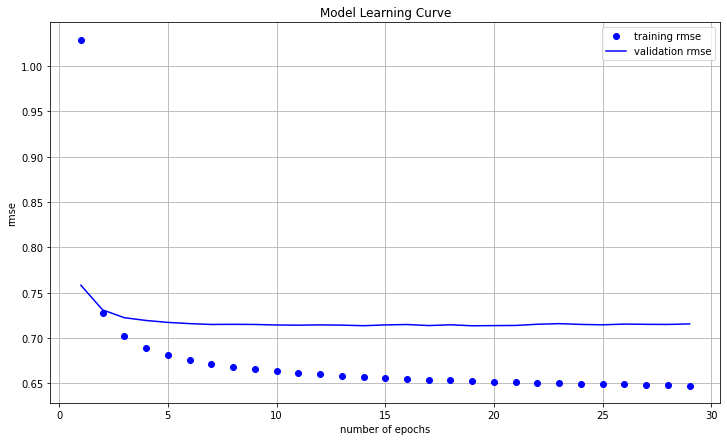

In [ ]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_learning_curve(history, 'rmse')


In [ ]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions1) - np.squeeze(df_test.rating.values))))

In [ ]:
# load best model
GMF_model = get_GMF_model(num_user, num_book, latent_dim, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions1 = GMF_model.predict([df_test.user_id.values, df_test.book_id.values])
# get the RMSE
error1 = rmse(df_test.rating.values, predictions1)
print('The out-of-sample RMSE of rating predictions is', round(error1, 4))

9344/9344 [==============================] - 6s 665us/step
The out-of-sample RMSE of rating predictions is 0.7219


## MLP model

In [ ]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology

    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)

    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)

    # Stitch input and output
    model = Model([user_input, item_input], prediction)

    return model

In [ ]:
MLP_model = get_MLP_model(num_user, num_book, [32, 16, 8], [0, 0, 0])
MLP_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 16)                139664    ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 16)                124640    ['item_input[0][0]']          
                                                                                            

In [ ]:
# model config
BATCH_SIZE = 32
EPOCHS = 30
VAL_SPLIT = 0.20

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT,
                      inputs=[df_train.user_id.values, df_train.book_id.values],
                      outputs=df_train.rating.values)

Epoch 1/30
29901/29901 [==============================] - 64s 2ms/step - loss: 0.6547 - mean_squared_error: 0.6547 - rmse: 0.7784 - val_loss: 0.5707 - val_mean_squared_error: 0.5707 - val_rmse: 0.7468
Epoch 2/30
29901/29901 [==============================] - 63s 2ms/step - loss: 0.5526 - mean_squared_error: 0.5526 - rmse: 0.7346 - val_loss: 0.5537 - val_mean_squared_error: 0.5537 - val_rmse: 0.7357
Epoch 3/30
29901/29901 [==============================] - 63s 2ms/step - loss: 0.5350 - mean_squared_error: 0.5350 - rmse: 0.7225 - val_loss: 0.5434 - val_mean_squared_error: 0.5434 - val_rmse: 0.7283
Epoch 4/30
29901/29901 [==============================] - 63s 2ms/step - loss: 0.5183 - mean_squared_error: 0.5183 - rmse: 0.7109 - val_loss: 0.5398 - val_mean_squared_error: 0.5398 - val_rmse: 0.7254
Epoch 5/30
29901/29901 [==============================] - 63s 2ms/step - loss: 0.5024 - mean_squared_error: 0.5024 - rmse: 0.6999 - val_loss: 0.5311 - val_mean_squared_error: 0.5311 - val_rmse: 0.

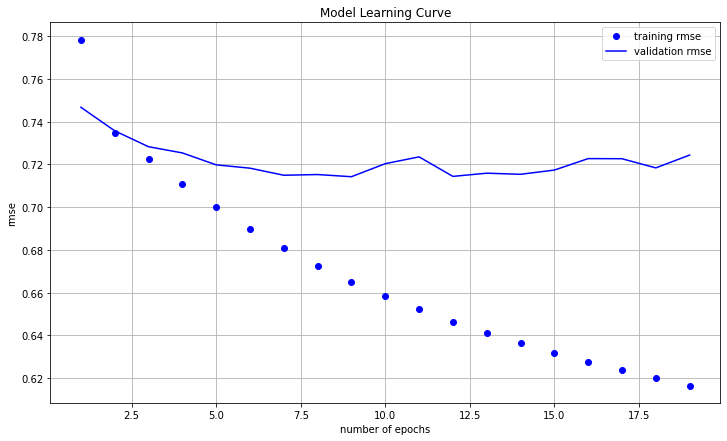

In [ ]:
plot_learning_curve(history, 'rmse')

In [ ]:
# load best model
MLP_model = get_MLP_model(num_user, num_book, [32, 16, 8], [0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions2 = MLP_model.predict([df_test.user_id.values, df_test.book_id.values])
# get the RMSE
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions2) - np.squeeze(df_test.rating.values))))
error2 = rmse(df_test.rating.values, predictions2)
print('The out-of-sample RMSE of rating predictions is', round(error2, 4))


9344/9344 [==============================] - 7s 726us/step
The out-of-sample RMSE of rating predictions is 0.7245


## Train Neural Matrix Factorization (NeuMF) and Test Model

In [ ]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP

    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer

    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)

    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)

    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)

    # Stitch input and output
    model = Model([user_input, item_input], prediction)

    return model

In [ ]:
NeuMF_model = get_NeuMF_model(
    num_users=num_user,
    num_items=num_book,
    MF_dim=6,
    MF_reg=(0, 0),
    MLP_layers=[32, 16, 8],
    MLP_regs=[0, 0, 0])
NeuMF_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 mlp_user_embedding (Embedd  (None, 1, 16)                139664    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 mlp_item_embedding (Embedd  (None, 1, 16)                124640    ['item_input[0][0]']    

In [ ]:
# model config
BATCH_SIZE = 32
EPOCHS = 30
VAL_SPLIT = 0.10

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT,
                      inputs=[df_train.user_id.values, df_train.book_id.values],
                      outputs=df_train.rating.values)

Epoch 1/30
33638/33638 [==============================] - 112s 3ms/step - loss: 0.6446 - mean_squared_error: 0.6446 - rmse: 0.7702 - val_loss: 0.5443 - val_mean_squared_error: 0.5443 - val_rmse: 0.7287
Epoch 2/30
33638/33638 [==============================] - 101s 3ms/step - loss: 0.4999 - mean_squared_error: 0.4999 - rmse: 0.6978 - val_loss: 0.5230 - val_mean_squared_error: 0.5230 - val_rmse: 0.7139
Epoch 3/30
33638/33638 [==============================] - 98s 3ms/step - loss: 0.4658 - mean_squared_error: 0.4658 - rmse: 0.6732 - val_loss: 0.5193 - val_mean_squared_error: 0.5193 - val_rmse: 0.7112
Epoch 4/30
10392/33638 [========>.....................] - ETA: 1:05 - loss: 0.4314 - mean_squared_error: 0.4314 - rmse: 0.6476

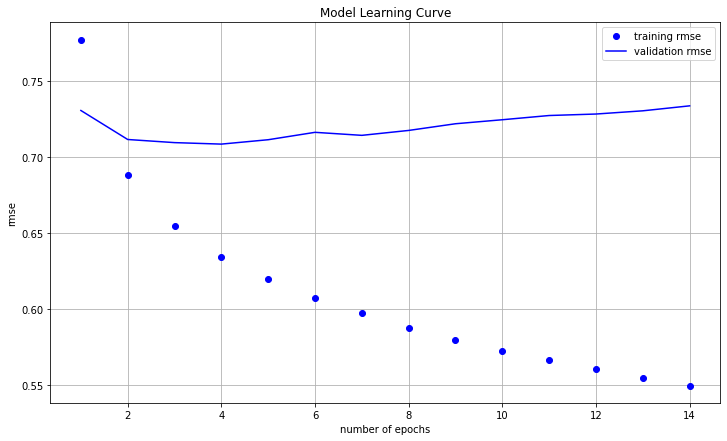

In [ ]:
plot_learning_curve(history, 'rmse')

In [ ]:
# load best model
NeuMF_model = get_NeuMF_model(
    num_users=num_user,
    num_items=num_book,
    MF_dim=6,
    MF_reg=(0, 0),
    MLP_layers=[32, 16, 8],
    MLP_regs=[0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions3) - np.squeeze(df_test.rating.values))))
predictions3 = NeuMF_model.predict([df_test.user_id.values, df_test.book_id.values])
# get the RMSE
error3 = rmse(df_test.rating.values, predictions3)
print('The out-of-sample RMSE of rating predictions is', round(error3, 4))

9344/9344 [==============================] - 8s 798us/step
The out-of-sample RMSE of rating predictions is 0.7188
